# Project: Chatbot for Manulife
This project implements a chatbot system designed to assist users with a variety of tasks, featuring the following key capabilities:  
- **Conversation memory**: Retains context across user interactions.  
- **Retrieval-Augmented Generation (RAG)**: Answers user questions by retrieving relevant information from documents.  
- **Internet search**: Handles queries requiring up-to-date or information beyond the knowledge of a large language model (LLM).

## Chatbot System Overview
The system is comprised of two specialized agents: **Receptionist** and **Insurance Advisor**, each tailored to handle different types of queries. 

### **Receptionist**
The Receptionist agent is responsible for:  
- Answering general questions that can be handled by a large language model (LLM).  
- Retrieving information from the 2023 Manulife Annual Report to address finance-related queries specific to Manulife.  
- Performing web searches to provide answers for questions outside its built-in knowledge base (e.g., "What is the current weather in Hong Kong?").  

### **Insurance Advisor**
The Insurance Advisor agent specializes in:  
- Offering personalized recommendations for purchasing any type of insurance package.  

## Agent Collaboration
The two agents work collaboratively as follows:  
- If a user's query **is not related to purchasing insurance**, the Receptionist agent provides the response.  
- If a user's query **concerns purchasing an insurance package**, the conversation is transferred to the Insurance Advisor for further assistance.

## State Graph
Below is a graphical representation of the chatbot system's workflow: 

![Manulife Chatbot Diagram](img/state_graph_langgraph.png "Chatbot System Overview")

## Technologies Used
- This project uses LangChain and LangGraph, among other dependencies.

## import necessary dependencies

In [1]:
from IPython.display import Image, display
from typing_extensions import List, TypedDict, Annotated
from typing import Annotated, Literal
import uuid
from IPython.core.interactiveshell import InteractiveShell; InteractiveShell.ast_node_interactivity = "all"

# LLM 
from google.cloud import aiplatform
from langchain_google_vertexai import ChatVertexAI

# RAG
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader

# memory 
from langgraph.checkpoint.memory import MemorySaver

# embedding
from langchain_google_vertexai import VertexAIEmbeddings

# vector store
from langchain_core.vectorstores import InMemoryVectorStore

# tool
from langchain_core.tools import tool

# web search
from langchain_community.tools.tavily_search import TavilySearchResults

# langraph
from langgraph.graph import START, MessagesState, StateGraph
from langgraph.prebuilt import create_react_agent 
from langgraph.types import Command, interrupt
from langchain_core.tools.base import InjectedToolCallId
from langgraph.prebuilt import InjectedState

## Define LLM model to use

In [2]:
model = ChatVertexAI(
    model="gemini-2.0-flash-exp",
    temperature=0,
    top_k=1,
    max_tokens=None,
    max_retries=6,
    stop=None,
    # other params...
)

# Define document handler, embedding, and vector store

In [3]:
file_path = "doc/manulife_annual_report_2023.pdf"

# define file handler
loader = PyPDFLoader(file_path)
docs = loader.load()
print(f"{len(docs) = }")

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

print(f"{len(all_splits) = }")

# define embedding
embeddings = VertexAIEmbeddings(model="text-embedding-004")

# define vector store
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(documents=all_splits)

memory = MemorySaver()

len(docs) = 288
len(all_splits) = 1644


In [5]:
# len(all_splits[10].page_content)
# len(all_splits[14].page_content)
# print(all_splits[10].page_content)

## Define tools for tool calling

In [7]:
# search the manulife document for information
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Use this tool to retrieve and summarize information from the Manulife 2023 annual report."""
    retrieved_docs = vector_store.similarity_search(query, k=3)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

# for searching the internet
search = TavilySearchResults(max_results=2)

# transfer from one agent to another agent
# Purpose: Transfers queries from one agent to another.
# make_handoff_tool(agent_name="agent_X") creates a function named transfer_to_agent_X for passing requests.
# handoff_to_agent:
    # Adds a tool message indicating that the query has been transferred.
    # Calls Command(goto=agent_name, graph=Command.PARENT, update=...), which:
        # Moves the conversation to agent_name.
        # Updates the chat history with a message about the transfer.
# Useful for multi-agent systems where different agents specialize in different topics.
def make_handoff_tool(*, agent_name: str):
    """Create a tool that can return handoff via a Command"""
    tool_name = f"transfer_to_{agent_name}"

    @tool(tool_name)
    def handoff_to_agent(
        state: Annotated[dict, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Ask another agent for help."""
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": tool_name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            # navigate to another agent node in the PARENT graph
            goto=agent_name,
            graph=Command.PARENT,
            # This is the state update that the agent `agent_name` will see when it is invoked.
            # We're passing agent's FULL internal message history AND adding a tool message to make sure
            # the resulting chat history is valid.
            update={"messages": state["messages"] + [tool_message]},
        )

    return handoff_to_agent

## Define agents

In [5]:
receptionist_tools = [
    retrieve, 
    search, 
    make_handoff_tool(agent_name='insurance_advisor')
]

receptionist = create_react_agent(
    model, 
    receptionist_tools, 
    state_modifier= (
        "You are a receptionist answering general conversation bot for the insurance company Manulife. If users ask for insurance purchase recommendation, ask 'insurance_advisor' for help. "
    )
)

insurance_advisor_tools = [
    search,
    make_handoff_tool(agent_name='receptionist'),
]

insurance_advisor = create_react_agent(
    model,
    insurance_advisor_tools,
    state_modifier=(
        "You are a insurance expert who provides recommendations for purchasing any kind of insurance package. "
        "You must explain the reason of your recommendation and the general benefits of this insurance package. "
        "If users ask for questions unrelated to purchasing insurance package recommendation, ask 'receptionist' for help. "
    ),
)

## Define state graph

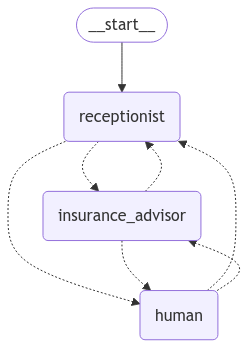

In [8]:
def call_receptionist(
    state: MessagesState,
) -> Command[Literal['insurance_advisor', "human"]]:
    response = receptionist.invoke(state)
    return Command(update=response, goto="human")

def call_insurance_advisor(
    state: MessagesState,
) -> Command[Literal["receptionist", "human"]]:
    response = insurance_advisor.invoke(state)
    return Command(update=response, goto="human")

def human_node(
    state: MessagesState, 
    config
) -> Command[Literal["receptionist", "insurance_advisor"]]:
# ) -> Command[Literal["receptionist", "insurance_advisor", "human"]]:
    """A node for collecting user input."""

    user_input = interrupt(value="Ready for user input.")

    # identify the last active agent
    # (the last active node before returning to human)
    langgraph_triggers = config["metadata"]["langgraph_triggers"]
    if len(langgraph_triggers) != 1:
        raise AssertionError("Expected exactly 1 trigger in human node")

    active_agent = langgraph_triggers[0].split(":")[1]

    return Command(
        update={
            "messages": [
                {
                    "role": "human",
                    "content": user_input,
                }
            ]
        },
        goto=active_agent,
    )


builder = StateGraph(MessagesState)
builder.add_node("receptionist", call_receptionist)
builder.add_node("insurance_advisor", call_insurance_advisor)
builder.add_node("human", human_node)
builder.add_edge(START, "receptionist")
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

display(Image(graph.get_graph().draw_mermaid_png()))

## start conversation with agents

In [7]:
# use uuid to get a random thread_id
thread_config = {"configurable": {"thread_id": uuid.uuid4()}}

print("Type 'exit' to end the conversation.")
count = 0
while True:
    user_input = input("\nYou: ")
    
    if user_input.lower() == "exit":
        print("Ending the conversation. Goodbye!")
        break

    count += 1

    print(f"--- Conversation Turn {count} ---")
    print(f"You: {user_input}")

    if count == 1:
        user_input = {
        "messages": [
            {"role": "user", "content": user_input}
        ]}
    else:
        user_input = Command(resume=user_input)

    for update in graph.stream(
        user_input,
        config=thread_config,
        stream_mode="updates",
    ):
        for node_id, value in update.items():
            if isinstance(value, dict) and value.get("messages", []):
                last_message = value["messages"][-1]
                if isinstance(last_message, dict) or last_message.type != "ai":
                    continue
                print(f"{node_id}: {last_message.content}")

Type 'exit' to end the conversation.
--- Conversation Turn 1 ---
You: hello!
receptionist: Hi there! How can I help you today?

--- Conversation Turn 2 ---
You: What is the total revenue in 2023 for manulife?
receptionist: Manulife's total revenue in 2023 was $48.739 billion.

--- Conversation Turn 3 ---
You: what is the weather in Hong Kong now?
receptionist: The weather in Hong Kong is currently clear with a temperature of 12.2°C. It's also quite windy, with a wind speed of 16.2 kph from the NNE.

--- Conversation Turn 4 ---
You: I want to buy insurance
insurance_advisor: Okay, I can help you with that! To give you the best recommendation, I need a little more information. What kind of insurance are you looking for? Are you interested in health, life, home, auto, or something else?

--- Conversation Turn 5 ---
You: what is life insurance?
insurance_advisor: Life insurance is a contract between you and an insurance company. In exchange for regular payments (premiums), the insurance co